In [93]:
from keras.layers import Lambda, Input, Dense, LeakyReLU, BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [49]:
data_dir = "data/"
stocks = pd.read_csv(data_dir + "ex_aktier.csv")
# stocks= stocks.groupby("Date").filter(lambda x: x["Isin"].count() > 100)
# # rates = pd.read_csv(data_dir + "rates_philip.csv", sep=";", decimal=",", index_col = 0, parse_dates=True)
# # cmdty = pd.read_csv(data_dir + "cmdty_philip.csv", sep=";", decimal=",", index_col = 0, parse_dates=True)
# # index = pd.read_csv(data_dir + "index.csv", index_col =0, parse_dates = True)
# # Y = rates.join(cmdty).join(index)
# stocks = stocks.pivot(index="Date", columns = "Isin", values="Close")
# stocks.index = pd.to_datetime(stocks.index)
# stocks = stocks.resample("W-Fri").first()
# X = stocks.pct_change().dropna(how="all")
# X[X == 0.0] = np.nan
# X = X.loc[:, X.count() > 100]
# mu = X.mean()
# std = X.std()
# X = X.sub(mu, axis=1).div(std, axis=1)


In [50]:
df = stocks.copy().set_index("Date")
df.index = pd.to_datetime(df.index)
df = df.loc["1999-12-31":"2020-03-31"]
df = df.set_index([df.index, "Isin"]).unstack()["Close"].pct_change()[1:]
df[df == 0.0] = np.nan
df = df.resample("W-Fri").first()
mu = df.mean()
std = df.std()
#df = df.sub(mu, axis=1).div(std, axis=1)

In [69]:
if True:
    TT = 5000
    nn = 1200
    S = np.zeros((TT,nn))
    dt = 1/252.
    for t in range(TT):
        w = np.random.randn(nn)
        mu = np.random.randn(nn)/10
        sigma = np.random.rand(nn)/10
        S[t] = mu*dt + sigma*np.sqrt(dt)*w
    df = pd.DataFrame(S)

In [82]:
T = 50
n = 5


X = []
steps = len(df) // T
windows = 1000

for t in range(steps-1):
    df_t = df.iloc[t*T:(t+1)*T].fillna(method="pad").dropna(axis=1)
    #df_t = df_t.sub(df_t.mean(), axis=1).div(df_t.std(), axis=1).dropna(axis=1)
    
    if df_t.shape[1] < n:
        continue
    for _ in range(windows):
        i = np.random.choice(np.arange(df_t.shape[1]), n, replace=False)
        df_t_i = df_t.iloc[:,i]
        #df_t_i = df_t_i.sub(df_t_i.mean(), axis=1).div(df_t_i.std(), axis=1)
        X.append(df_t_i.values.reshape(-1,1).squeeze())
    
    

X = np.array(X)
X.shape

(99000, 250)

In [83]:

train, test = train_test_split(X, test_size = 0.1, random_state = 42)
train_scaler = StandardScaler()
train = train_scaler.fit_transform(train)
test_scaler = StandardScaler()
test = test_scaler.fit_transform(test)

train.shape, test.shape

((89100, 250), (9900, 250))

In [95]:



# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon



# network parameters
original_dim = T*n
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 256
latent_dim = 64
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim)(inputs)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dense(intermediate_dim)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim)(latent_inputs)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dense(intermediate_dim)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)

outputs = Dense(original_dim)(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')



# VAE loss = mse_loss or xent_loss + kl_loss
reconstruction_loss = mse(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.fit(train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test, None))
    

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 250)          0                                            
__________________________________________________________________________________________________
dense_90 (Dense)                (None, 512)          128512      encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512)          2048        dense_90[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 512)          0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dense_91 (

89100/89100 [==============================] - 22s 246us/step - loss: 238.8117 - val_loss: 241.3169
Epoch 39/50
89100/89100 [==============================] - 22s 251us/step - loss: 238.7787 - val_loss: 241.2190
Epoch 40/50
89100/89100 [==============================] - 22s 251us/step - loss: 238.7774 - val_loss: 241.2601
Epoch 41/50
89100/89100 [==============================] - 22s 249us/step - loss: 238.7652 - val_loss: 241.2317
Epoch 42/50
89100/89100 [==============================] - 22s 250us/step - loss: 238.6958 - val_loss: 241.2617
Epoch 43/50
89100/89100 [==============================] - 22s 248us/step - loss: 238.6833 - val_loss: 241.2549
Epoch 44/50
89100/89100 [==============================] - 22s 249us/step - loss: 238.6742 - val_loss: 241.1797
Epoch 45/50
89100/89100 [==============================] - 23s 256us/step - loss: 238.6427 - val_loss: 241.1775
Epoch 46/50
89100/89100 [==============================] - 22s 248us/step - loss: 238.6387 - val_loss: 241.0512
Epoc

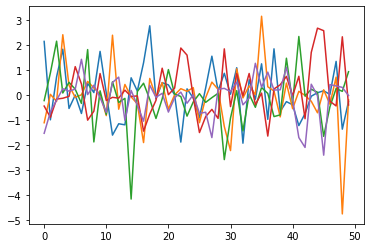

In [96]:
x = test[2].reshape(1,-1)
_ = plt.plot(x.reshape(T,n))

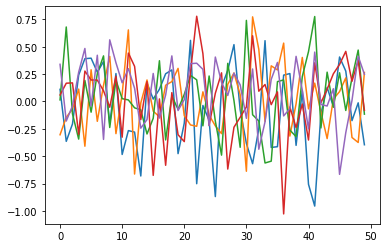

In [97]:
gen_x = vae.predict(x)
_ = plt.plot(gen_x.reshape(T,n))